#### imports

In [13]:
# Import qiskit modules.
from qiskit import QuantumCircuit, assemble, Aer, execute, IBMQ
from qiskit.tools import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex

# Import other modules.
import numpy as np
from plyer import notification
from time import time

#### create quantum circuit

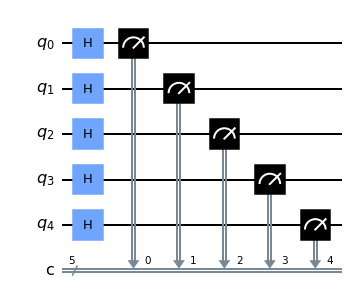

In [14]:
# Get # of qubits for quantum circuit and range of random num
def init_gen():
    n_qubits = int(input('Choose # of qubits (limit: 5) -> '))
    _min = int(input('Choose min'))
    _max = int(input('Choose max'))

    if n_qubits > 6:
        init_gen()
    else:
        return n_qubits, _min, _max


n_qubits, _min, _max = init_gen()

qc = QuantumCircuit(n_qubits, n_qubits)

for i in range(n_qubits):
    qc.h(i)

qc.measure(range(n_qubits), range(n_qubits))

qobj = assemble(qc)

qc.draw(output='mpl')

#### run circuit on quantum computer

In [15]:
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q')

start_time = time()

# Get least busy computer.
qcomp = provider.get_backend('ibmq_athens')
print('Running on', qcomp)

# NOTE: To choose the best backend, check: https://quantum-computing.ibm.com/services?systems=yours

# Run circuit.  
job = execute(qc, backend=qcomp, memory=True)
job_monitor(job)

result = job.result()

state = result.get_memory(qc)[0]
elapsed = (time() - start_time)/60

print('state ->', state)
print(f'elapsed -> {elapsed:.2f} min.')

statevectors = [
    [1, 0],
    [0, 1]
]

for i, qubit_state in enumerate(state):
    qc.initialize(statevectors[int(qubit_state)], i)

qc.draw()

qobj = assemble(qc)

# # NOTE: The reason why we re-initialize the state as the result of the simulation
# #       is so that we can represent that state on a bloch sphere.

simulator = Aer.get_backend('statevector_simulator')

job = simulator.run(qobj)
statevector = job.result().get_statevector(qc)

plot_bloch_multivector(statevector)


notification.notify(
    title='Quantum Circuit Sim Results',
    message=f'elapsed -> {elapsed:.2f} min.\nstate -> {state}',
    app_icon='qiskit_icon.ico'
)

ibmqfactory.load_account:WARNING:2021-06-06 21:46:36,730: Credentials are already in use. The existing account in the session will be replaced.


Running on ibmq_athens
Job Status: job has successfully run
state -> 11111
elapsed -> 0.40 min.


#### convert statevector to random number

In [16]:
# Produce random number based on the results from experiment.
def real_map(value, left_min, left_max, right_min, right_max):
    # Figure out how 'wide' each range is.
    left_span = left_max - left_min
    right_span = right_max - right_min

    # Convert the left range into a 0-1 range (float) NOTE: This is the equation that finalizes the num.
    value_scaled = float(value - left_min) / float(left_span)

    # Convert the 0-1 range into a value in the right range.
    return right_min + (value_scaled * right_span)

n1, n2, n3 = (0, 0, 0)
for i in range(statevector.size):
    if abs(statevector[i]) != 0:
        n1 = i
        n2 = np.real(statevector[i])
        n3 = np.imag(statevector[i])

print(
    real_map(
        n1 + n2+ n3,
        -n_qubits,
        len(statevector) - 1 + n_qubits,
        _min,
        _max
    )
)


0.9024390243902439
